# Bayesian Equivalence Testing and Plotting

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statistics import stdev
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
import warnings
warnings.filterwarnings("ignore")

os.environ['R_HOME'] = 'C:/Users/kjl113/Anaconda3/lib/R'

from rpy2.robjects import r, pandas2ri, conversion
from rpy2.robjects.packages import importr
pandas2ri.activate()
bayestest = importr('bayestestR')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
azdf1 = az.from_netcdf('ddmrace_fixedalpha_study1_2.nc')
azdf2 = az.from_netcdf('ddmrace_fixedalpha_study3.nc')
azdf3 = az.from_netcdf('ddmrace_freealpha_study1_2.nc')
azdf4 = az.from_netcdf('ddmrace_freealpha_study3.nc')

## Experiments 1 and 2 Valence Contrasts

[Text(0, 0, '25% Black'), Text(1, 0, '50% Black'), Text(2, 0, '75% Black')]

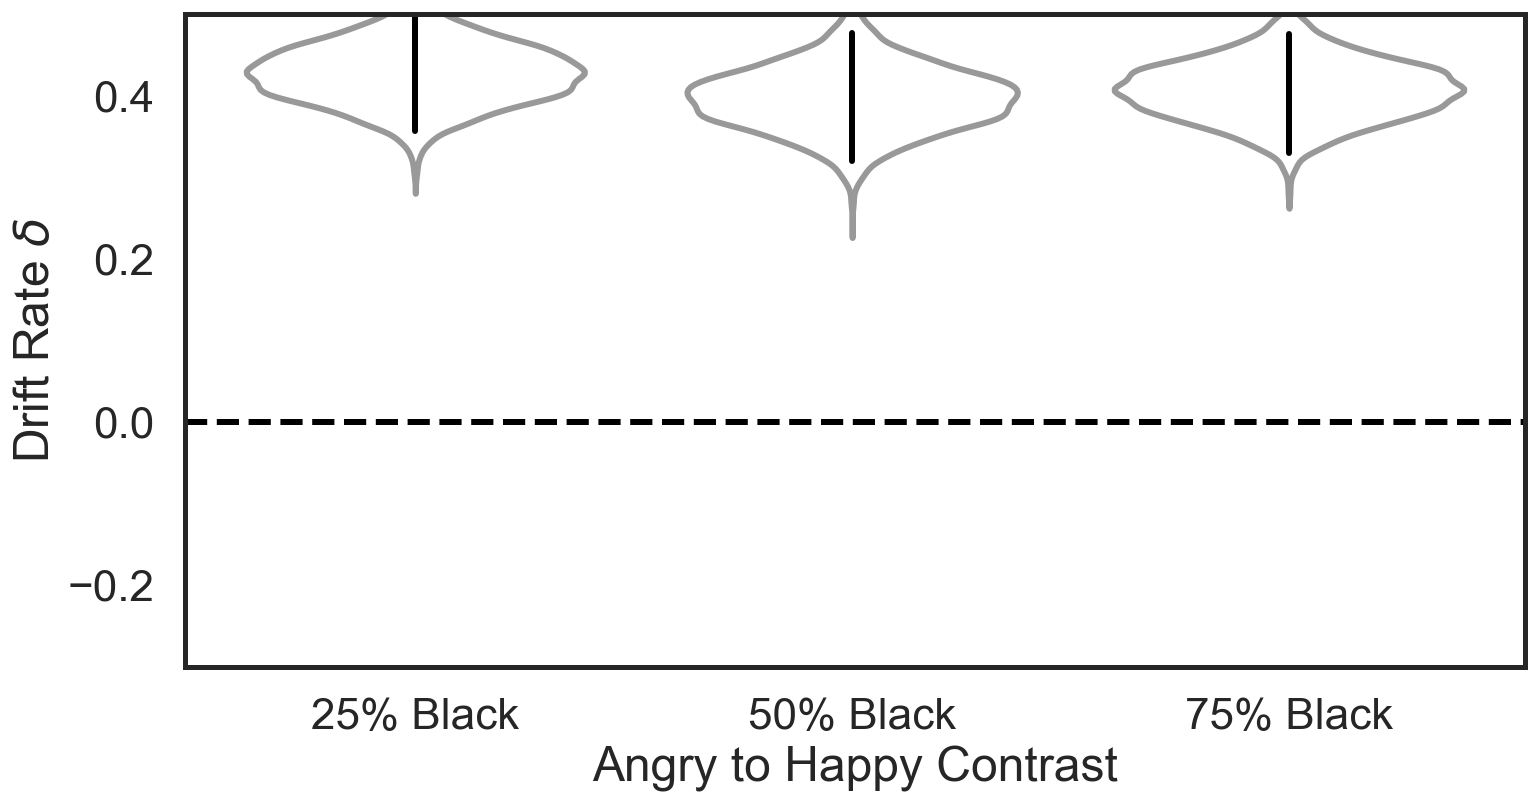

In [3]:
modeldata = azdf1

convdict = {'_happy_b25': 'Happy25%Black', '_happy_b50': 'Happy50%Black', '_happy_b75': 'Happy75%Black', 
            '_angry_b25': 'Angry25%Black', '_angry_b50': 'Angry50%Black', '_angry_b75': 'Angry75%Black'}

hdint = 0.95
fig, ax = plt.subplots(figsize=(12,6))
groupeddata = pd.DataFrame()
hdis = []

for group, contrasts in enumerate([['Angry25%Black - Happy25%Black', 'Angry50%Black - Happy50%Black', 'Angry75%Black - Happy75%Black']]):
    hdilist=[]
    for c in contrasts:
        compdict={}
        violinlist=[]; labellist=[]
        for x in ['delta']:
            compdf = pd.DataFrame({'reference':convdict.values()})
            for i, y in enumerate(convdict.keys()):
                compdftemp = []
                for j, z in enumerate(convdict.keys()):
                    sdf = pd.DataFrame({'mu_'+x+y: modeldata.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                       'mu_'+x+z: modeldata.posterior['mu_'+x+z].mean(dim=['chain']).values})
                    var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                    hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                    vart = {'%s' % (convdict[y][5:]+' - '+convdict[z][5:]): np.array(var)}
                    if convdict[y]+' - '+convdict[z] == c: 
                        violinlist.append(var)
                        labellist.append([convdict[y][5:]+' - '+convdict[z][5:]]*len(var))
                        hdilist.append(hdi)

        violinlist = [item for sublist in violinlist for item in sublist]
        labellist = [item for sublist in labellist for item in sublist]
        valence = ['Happy', 'Angry']
        vdf = pd.DataFrame({"contrast":labellist, 'samples':violinlist, 'valence':[valence[group]]*len(violinlist)})
        groupeddata = pd.concat([groupeddata, vdf])
    hdis.append(hdilist)
    
sns.set_style("whitegrid", {'axes.grid' : False})
sns.violinplot(x="contrast", y="samples", data=groupeddata, inner=None, color='w', ax=ax)
ax.axhline(y=0, color='black', linestyle='--')
for i, x in enumerate(hdis):
    for j, y in enumerate(x):
        plt.plot([j, j], [y[1], y[2]], 'k-')
ax.set_ylabel(r'Drift Rate $\delta$')
ax.set_ylim(-0.3, 0.5)
# ax.set_ylim(-0.1, 0.1)
# ax.set_ylim(-0.2, 0.2)
ax.set_xlabel('Angry to Happy Contrast')
ax.set_xticklabels(['25% Black' , '50% Black', '75% Black'], rotation=0)

## Experiments 1 and 2 Race Contrasts

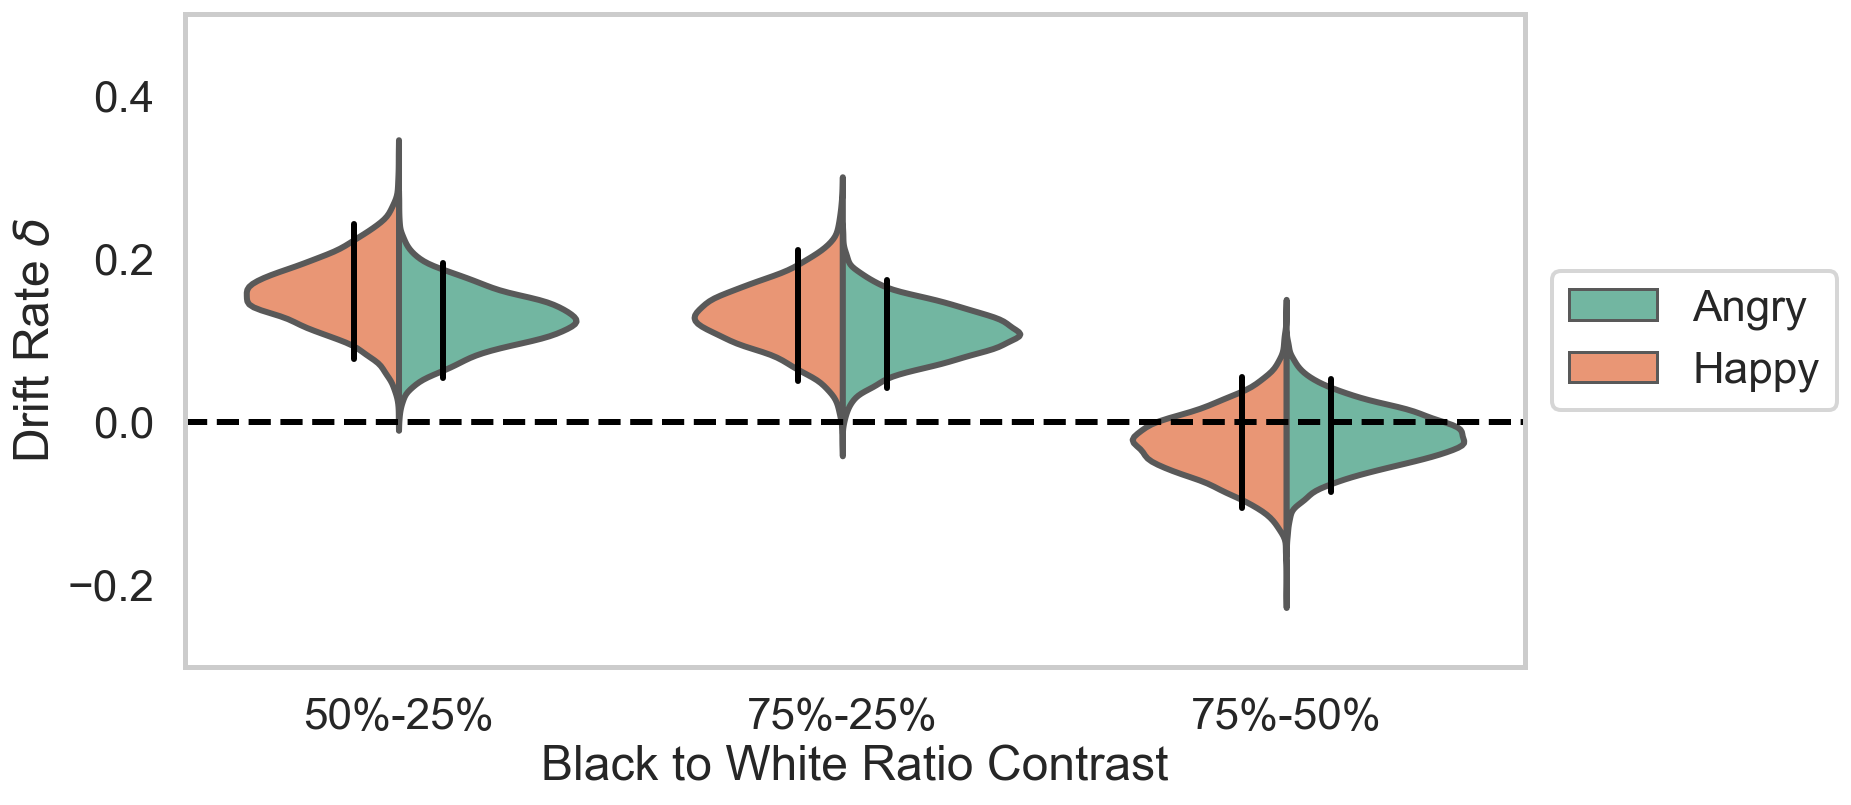

In [4]:
modeldata = azdf1

convdict = {'_happy_b25': 'Happy25%Black', '_happy_b50': 'Happy50%Black', '_happy_b75': 'Happy75%Black', 
            '_angry_b25': 'Angry25%Black', '_angry_b50': 'Angry50%Black', '_angry_b75': 'Angry75%Black'}

hdint = 0.95
fig, ax = plt.subplots(figsize=(12,6))
groupeddata = pd.DataFrame()
hdis = []

for group, contrasts in enumerate([['Happy50%Black - Happy25%Black', 'Happy75%Black - Happy25%Black', 'Happy75%Black - Happy50%Black'],
                 ['Angry50%Black - Angry25%Black', 'Angry75%Black - Angry25%Black', 'Angry75%Black - Angry50%Black']]):
    
    hdilist=[]
    for c in contrasts:
        compdict={}
        violinlist=[]; labellist=[]
        for x in ['delta']: #change to either alpha, zed, or delta
            compdf = pd.DataFrame({'reference':convdict.values()})
            for i, y in enumerate(convdict.keys()):
                compdftemp = []
                for j, z in enumerate(convdict.keys()):
                    sdf = pd.DataFrame({'mu_'+x+y: modeldata.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                       'mu_'+x+z: modeldata.posterior['mu_'+x+z].mean(dim=['chain']).values})
                    var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                    hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                    vart = {'%s' % (convdict[y][5:]+' - '+convdict[z][5:]): np.array(var)}
                    if convdict[y]+' - '+convdict[z] == c: 
                        violinlist.append(var)
                        labellist.append([convdict[y][5:]+' - '+convdict[z][5:]]*len(var))
                        hdilist.append(hdi)

        violinlist = [item for sublist in violinlist for item in sublist]
        labellist = [item for sublist in labellist for item in sublist]
        valence = ['Happy', 'Angry']
        vdf = pd.DataFrame({"contrast":labellist, 'samples':violinlist, 'valence':[valence[group]]*len(violinlist)})
        groupeddata = pd.concat([groupeddata, vdf])
    hdis.append(hdilist)
    
sns.set_style("whitegrid", {'axes.grid' : False})
sns.violinplot(x="contrast", y="samples", data=groupeddata, inner=None, color='w', ax=ax, hue='valence', 
               palette=[sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]], split=True)
ax.axhline(y=0, color='black', linestyle='--')
for i, x in enumerate(hdis):
    for j, y in enumerate(x):
        plt.plot([j-0.1+0.2*i, j-0.1+0.2*i], [y[1], y[2]], 'k-')
ax.set_ylabel(r'Drift Rate $\delta$') # change to reflect parameter
ax.set_ylim(-0.3, 0.5) # change for each parameter
# ax.set_ylim(-0.1, 0.1)
# ax.set_ylim(-0.2, 0.2)
ax.set_xlabel('Black to White Ratio Contrast')
ax.set_xticklabels(['50%-25%', '75%-25%', '75%-50%'], rotation=0)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center right', bbox_to_anchor=(1.25,0.5))

## Experiment 3 Valence Contrasts

[Text(0, 0, '0% Black'),
 Text(1, 0, '25% Black'),
 Text(2, 0, '50% Black'),
 Text(3, 0, '75% Black'),
 Text(4, 0, '100% Black')]

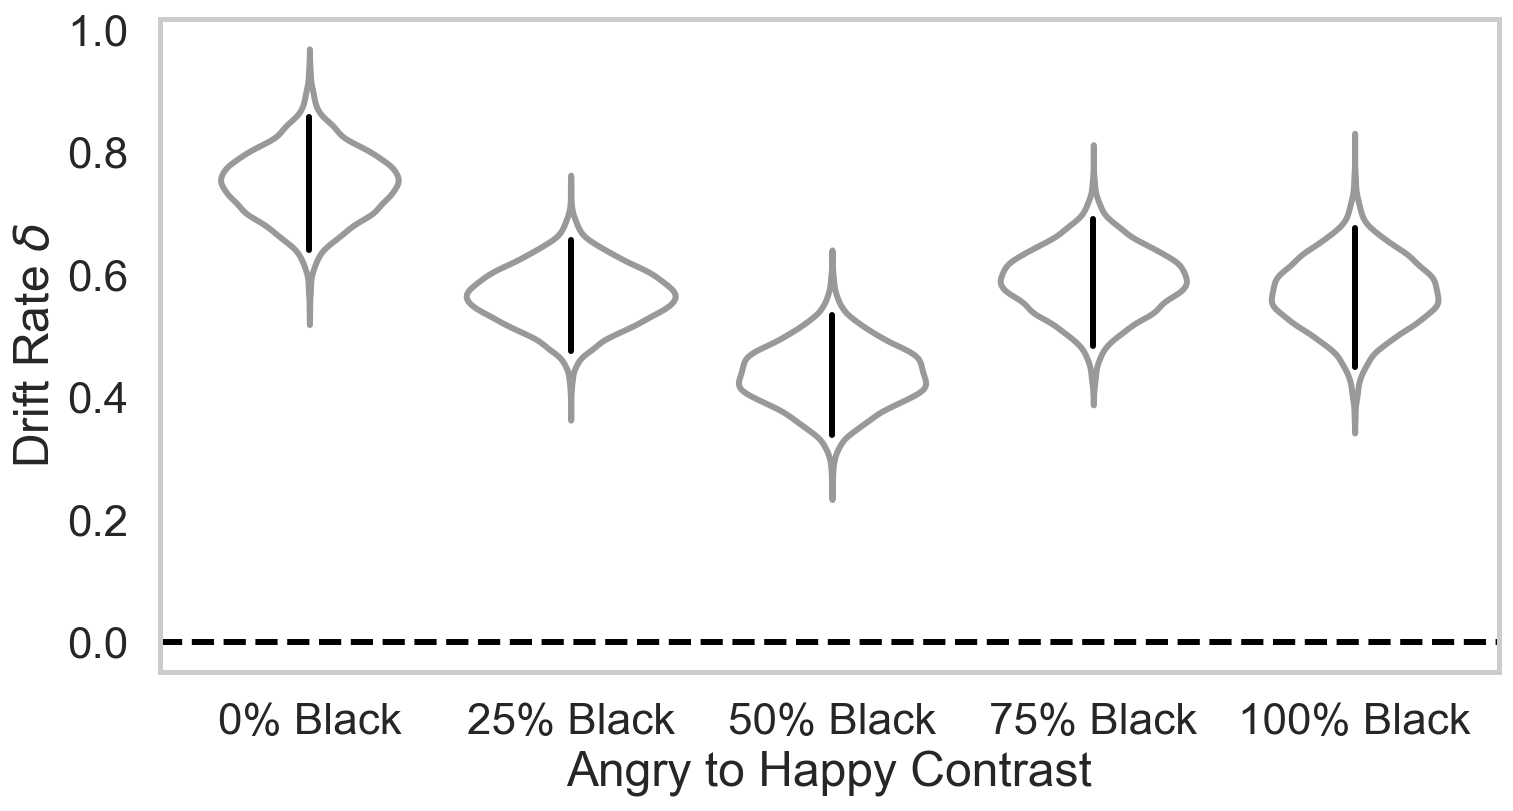

In [5]:
modeldata = azdf2

convdict = {'_happy_b0': 'Happy0%Black', '_happy_b25': 'Happy25%Black', '_happy_b50': 'Happy50%Black',
            '_happy_b75': 'Happy75%Black', '_happy_b1': 'Happy100%Black', '_angry_b0': 'Angry0%Black', 
            '_angry_b25': 'Angry25%Black', '_angry_b50': 'Angry50%Black', 
            '_angry_b75': 'Angry75%Black', '_angry_b1': 'Angry100%Black'}

hdint = 0.95
fig, ax = plt.subplots(figsize=(12,6))
groupeddata = pd.DataFrame()
hdis = []
    
for group, contrasts in enumerate([['Angry0%Black - Happy0%Black',
    'Angry25%Black - Happy25%Black', 'Angry50%Black - Happy50%Black', 'Angry75%Black - Happy75%Black',
                                   'Angry100%Black - Happy100%Black']]):
    hdilist=[]
    for c in contrasts:
        compdict={}
        violinlist=[]; labellist=[]
        for x in ['delta']:
            compdf = pd.DataFrame({'reference':convdict.values()})
            for i, y in enumerate(convdict.keys()):
                compdftemp = []
                for j, z in enumerate(convdict.keys()):
                    sdf = pd.DataFrame({'mu_'+x+y: modeldata.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                       'mu_'+x+z: modeldata.posterior['mu_'+x+z].mean(dim=['chain']).values})
                    var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                    hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                    vart = {'%s' % (convdict[y][5:]+' - '+convdict[z][5:]): np.array(var)}
                    if convdict[y]+' - '+convdict[z] == c: 
                        violinlist.append(var)
                        labellist.append([convdict[y][5:]+' - '+convdict[z][5:]]*len(var))
                        hdilist.append(hdi)

        violinlist = [item for sublist in violinlist for item in sublist]
        labellist = [item for sublist in labellist for item in sublist]
        valence = ['Happy', 'Angry']
        vdf = pd.DataFrame({"contrast":labellist, 'samples':violinlist, 'valence':[valence[group]]*len(violinlist)})
        groupeddata = pd.concat([groupeddata, vdf])
    hdis.append(hdilist)
    
sns.set_style("whitegrid", {'axes.grid' : False})
sns.violinplot(x="contrast", y="samples", data=groupeddata, inner=None, color='w', ax=ax)
ax.axhline(y=0, color='black', linestyle='--')
for i, x in enumerate(hdis):
    for j, y in enumerate(x):
        plt.plot([j, j], [y[1], y[2]], 'k-')
ax.set_ylabel(r'Drift Rate $\delta$')
# ax.set_ylim(-0.3, 0.5)
# ax.set_ylim(-0.1, 0.1)
ax.set_xlabel('Angry to Happy Contrast')
ax.set_xticklabels(['0% Black' , '25% Black', '50% Black', '75% Black', '100% Black'], rotation=0)

## Experiment 3 Race Contrasts

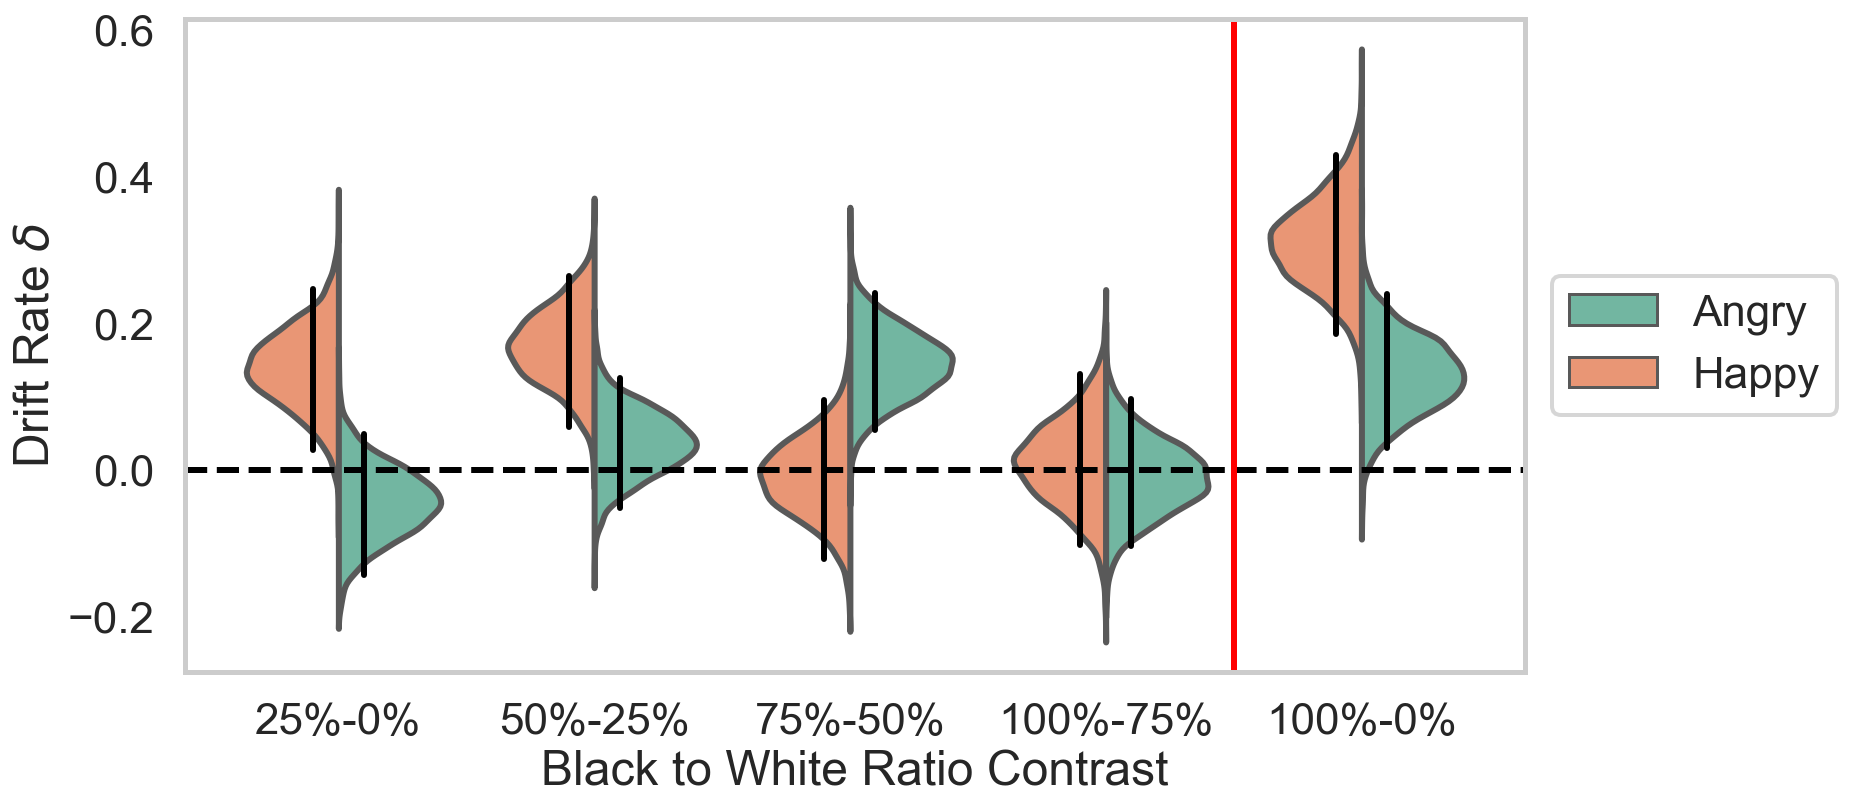

In [6]:
modeldata = azdf2

convdict = {'_happy_b0': 'Happy0%Black', '_happy_b25': 'Happy25%Black', '_happy_b50': 'Happy50%Black',
            '_happy_b75': 'Happy75%Black', '_happy_b1': 'Happy100%Black', '_angry_b0': 'Angry0%Black', 
            '_angry_b25': 'Angry25%Black', '_angry_b50': 'Angry50%Black', 
            '_angry_b75': 'Angry75%Black', '_angry_b1': 'Angry100%Black'}

hdint = 0.95
fig, ax = plt.subplots(figsize=(12,6))
groupeddata = pd.DataFrame()
hdis = []

for group, contrasts in enumerate([['Happy25%Black - Happy0%Black', 'Happy50%Black - Happy25%Black', 'Happy75%Black - Happy50%Black',
            'Happy100%Black - Happy75%Black', 'Happy100%Black - Happy0%Black'],
                 ['Angry25%Black - Angry0%Black', 'Angry50%Black - Angry25%Black', 'Angry75%Black - Angry50%Black',
            'Angry100%Black - Angry75%Black', 'Angry100%Black - Angry0%Black']]):
    
    hdilist=[]
    for c in contrasts:
        compdict={}
        violinlist=[]; labellist=[]
        for x in ['delta']:
            compdf = pd.DataFrame({'reference':convdict.values()})
            for i, y in enumerate(convdict.keys()):
                compdftemp = []
                for j, z in enumerate(convdict.keys()):
                    sdf = pd.DataFrame({'mu_'+x+y: modeldata.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                       'mu_'+x+z: modeldata.posterior['mu_'+x+z].mean(dim=['chain']).values})
                    var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                    hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                    vart = {'%s' % (convdict[y][5:]+' - '+convdict[z][5:]): np.array(var)}
                    if convdict[y]+' - '+convdict[z] == c: 
                        violinlist.append(var)
                        labellist.append([convdict[y][5:]+' - '+convdict[z][5:]]*len(var))
                        hdilist.append(hdi)

        violinlist = [item for sublist in violinlist for item in sublist]
        labellist = [item for sublist in labellist for item in sublist]
        valence = ['Happy', 'Angry']
        vdf = pd.DataFrame({"contrast":labellist, 'samples':violinlist, 'valence':[valence[group]]*len(violinlist)})
        groupeddata = pd.concat([groupeddata, vdf])
    hdis.append(hdilist)
    
sns.set_style("whitegrid", {'axes.grid' : False})
sns.violinplot(x="contrast", y="samples", data=groupeddata, inner=None, color='w', ax=ax, hue='valence', 
               palette=[sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]], split=True)
ax.axhline(y=0, color='black', linestyle='--')
for i, x in enumerate(hdis):
    for j, y in enumerate(x):
        plt.plot([j-0.1+0.2*i, j-0.1+0.2*i], [y[1], y[2]], 'k-')
ax.axvline(x=3.5, color='red')
ax.set_ylabel(r'Drift Rate $\delta$')
# ax.set_ylim(-0.3, 0.5)
# ax.set_ylim(-0.1, 0.1)
ax.set_xlabel('Black to White Ratio Contrast')
ax.set_xticklabels(['25%-0%', '50%-25%', '75%-50%', '100%-75%', '100%-0%'], rotation=0)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center right', bbox_to_anchor=(1.25,0.5))

## Experiments 1 and 2 Model Comparison

<AxesSubplot:xlabel='Log'>

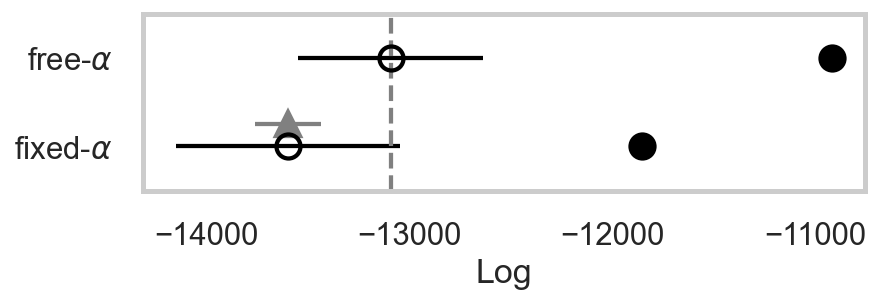

In [7]:
compare = az.compare({r'free-$\alpha$': azdf3, r'fixed-$\alpha$': azdf1}, ic='loo', scale='log')
az.plot_compare(compare)

## Experiment 3 Model Comparison

<AxesSubplot:xlabel='Log'>

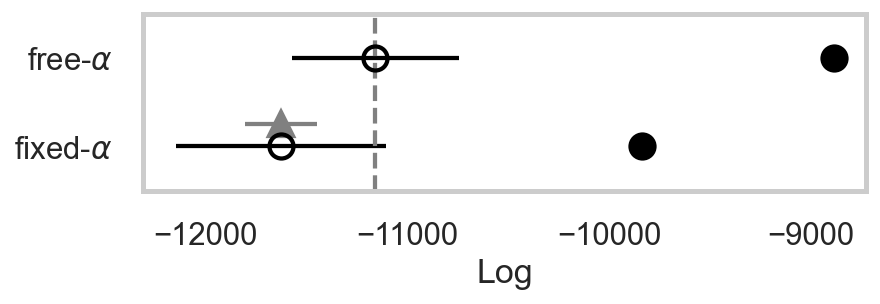

In [8]:
compare = az.compare({r'free-$\alpha$': azdf4, r'fixed-$\alpha$': azdf2}, ic='loo')
az.plot_compare(compare)

## Model Diagnostics

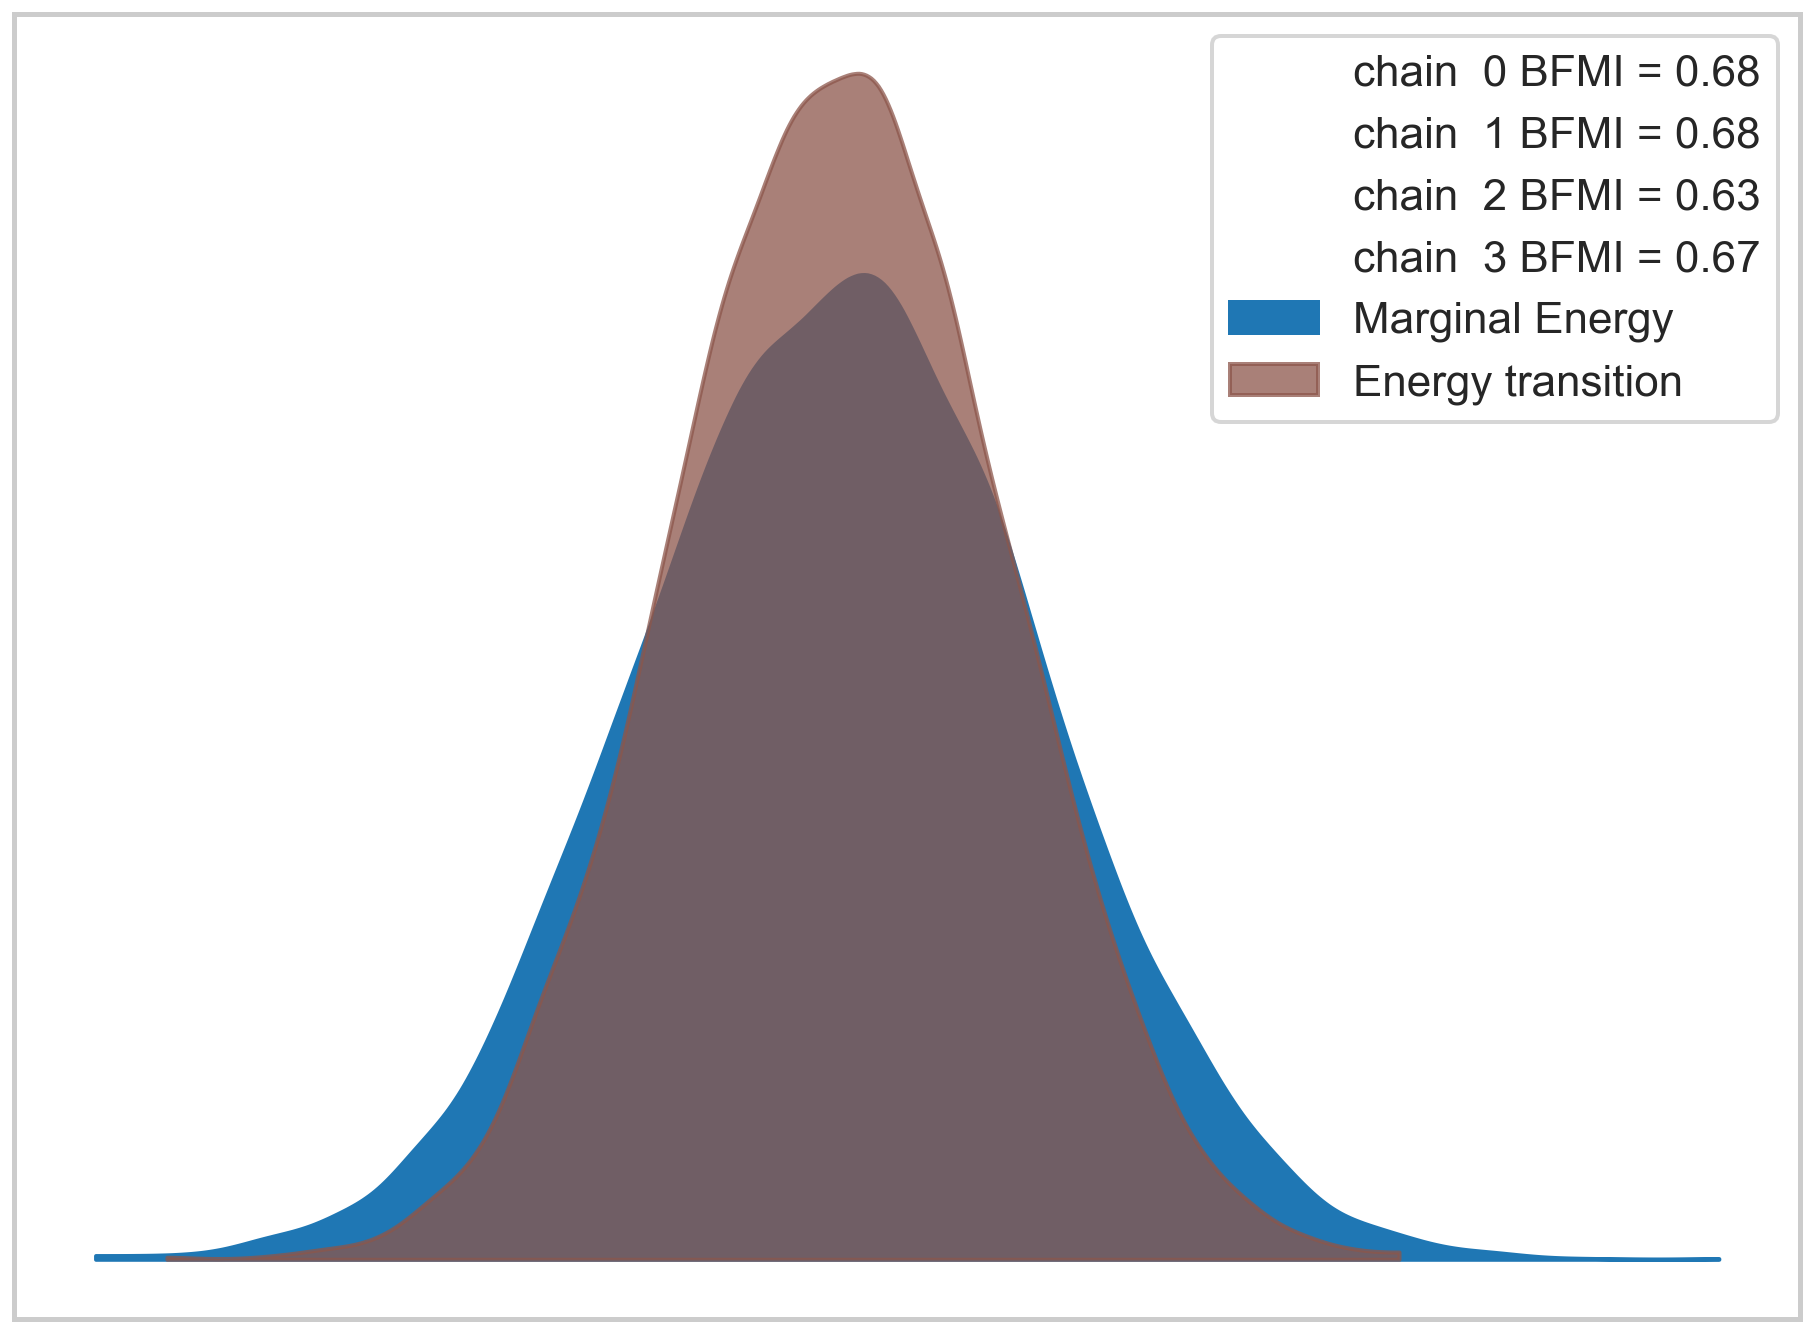

In [9]:
modeldata = azdf1

fig, ax = plt.subplots(figsize=(16, 12))
az.plot_energy(modeldata, ax=ax)
plt.show()

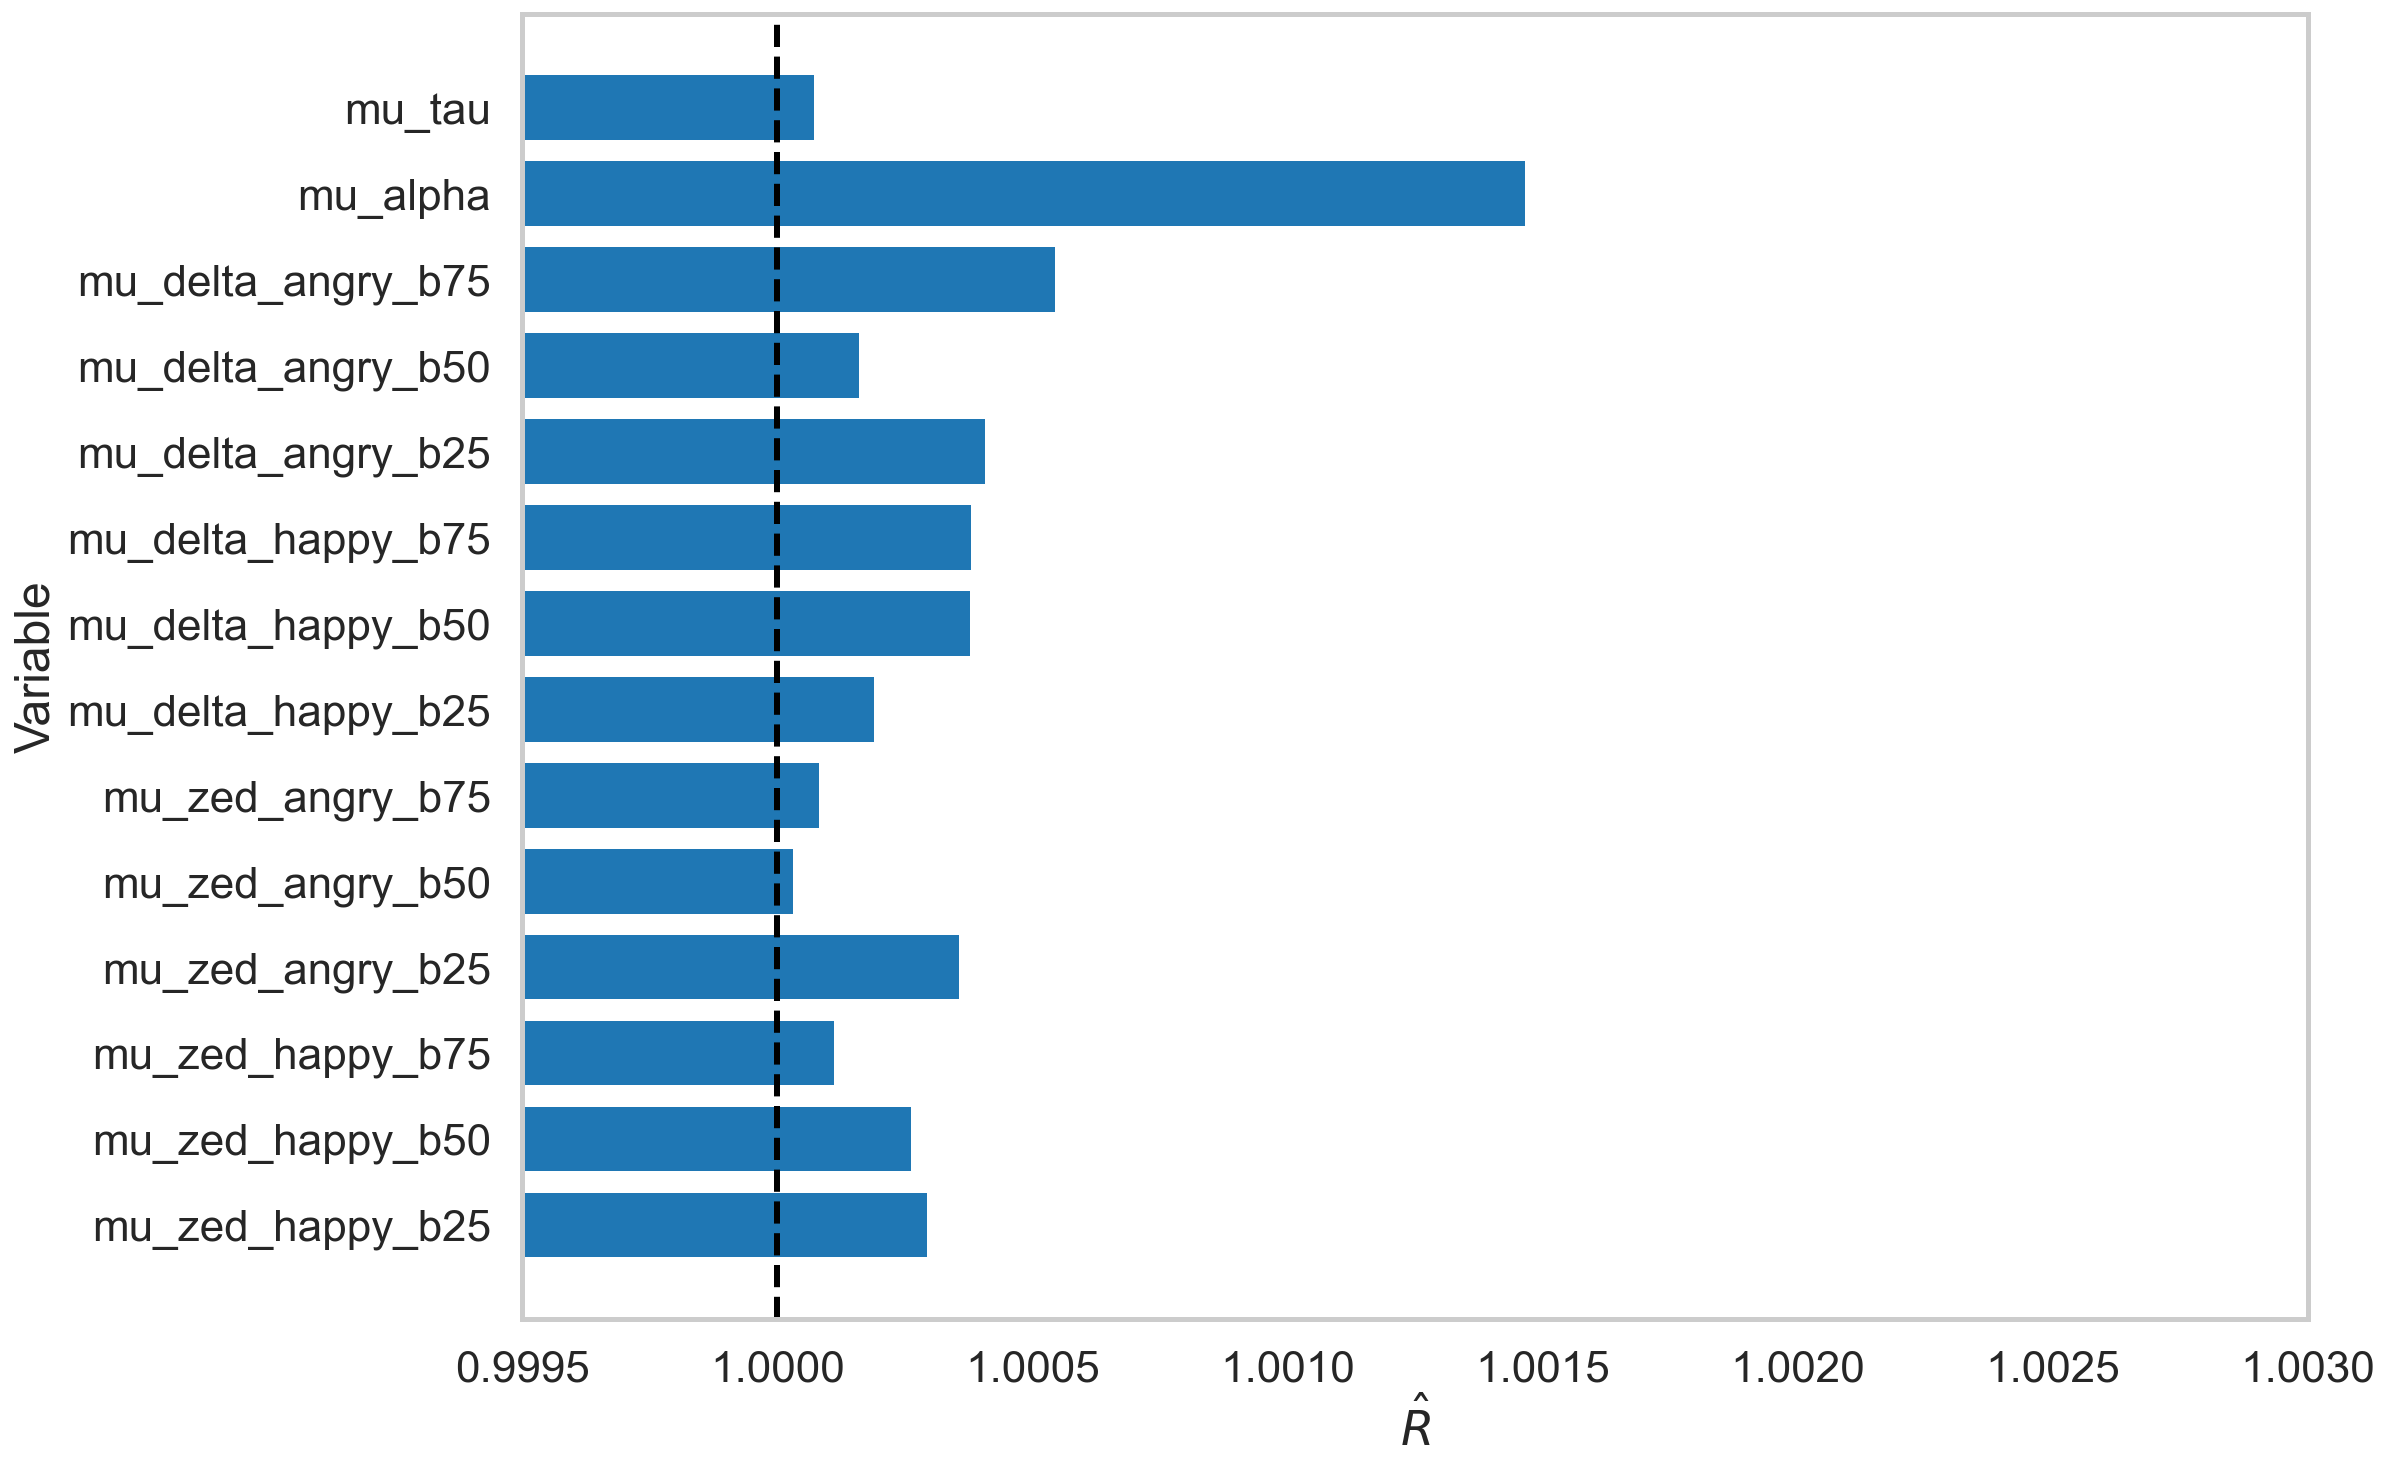

In [10]:
modeldata = azdf1

rhatvars = ['mu_zed_happy_b25', 'mu_zed_happy_b50', 'mu_zed_happy_b75',
 'mu_zed_angry_b25', 'mu_zed_angry_b50', 'mu_zed_angry_b75',
 'mu_delta_happy_b25', 'mu_delta_happy_b50', 'mu_delta_happy_b75',
 'mu_delta_angry_b25', 'mu_delta_angry_b50', 'mu_delta_angry_b75',
 'mu_alpha', 'mu_tau']

# rhatvars = ['mu_zed_happy_b0', 'mu_zed_happy_b25', 'mu_zed_happy_b50', 'mu_zed_happy_b75', 'mu_zed_happy_b1',
#  'mu_zed_angry_b0', 'mu_zed_angry_b25', 'mu_zed_angry_b50', 'mu_zed_angry_b75', 'mu_zed_angry_b1',
#  'mu_delta_happy_b0', 'mu_delta_happy_b25', 'mu_delta_happy_b50', 'mu_delta_happy_b75', 'mu_delta_happy_b1',
#  'mu_delta_angry_b0', 'mu_delta_angry_b25', 'mu_delta_angry_b50', 'mu_delta_angry_b75', 'mu_delta_angry_b1',
#  'mu_alpha', 'mu_tau']

def make_diagnostic_plots(modeldata, axes=None,
                          min_mult=0.995, max_mult=1.005,
                          var_names=None):
    if axes is None:
        fig, axes = plt.subplots(ncols=1,
                                 sharex=False, sharey=False,
                                 figsize=(16, 12))      
    rhat = az.rhat(modeldata, var_names=rhatvars).max()
    axes.barh(np.arange(len(rhat.variables)), rhat.to_array(), tick_label=list(rhat.variables.keys()))
    axes.axvline(1, c='k', ls='--')
    axes.set_xlim(
        min_mult * min(rhat.min().to_array().min(), 1),
        max_mult * max(rhat.max().to_array().max(), 1))
    axes.set_xlabel(r"$\hat{R}$")
    axes.set_ylabel("Variable") 
    axes.set_xlim(0.9995, 1.003)
    return fig, axes
make_diagnostic_plots(modeldata);

array([[<AxesSubplot:title={'center':'mu_zed_happy_b25'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_zed_happy_b50'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_zed_happy_b75'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_zed_angry_b25'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'mu_zed_angry_b50'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_zed_angry_b75'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_delta_happy_b25'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'mu_delta_happy_b50'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'mu_delta_happy_b75'}, xlabel='Quantile', ylabel='ESS for sma

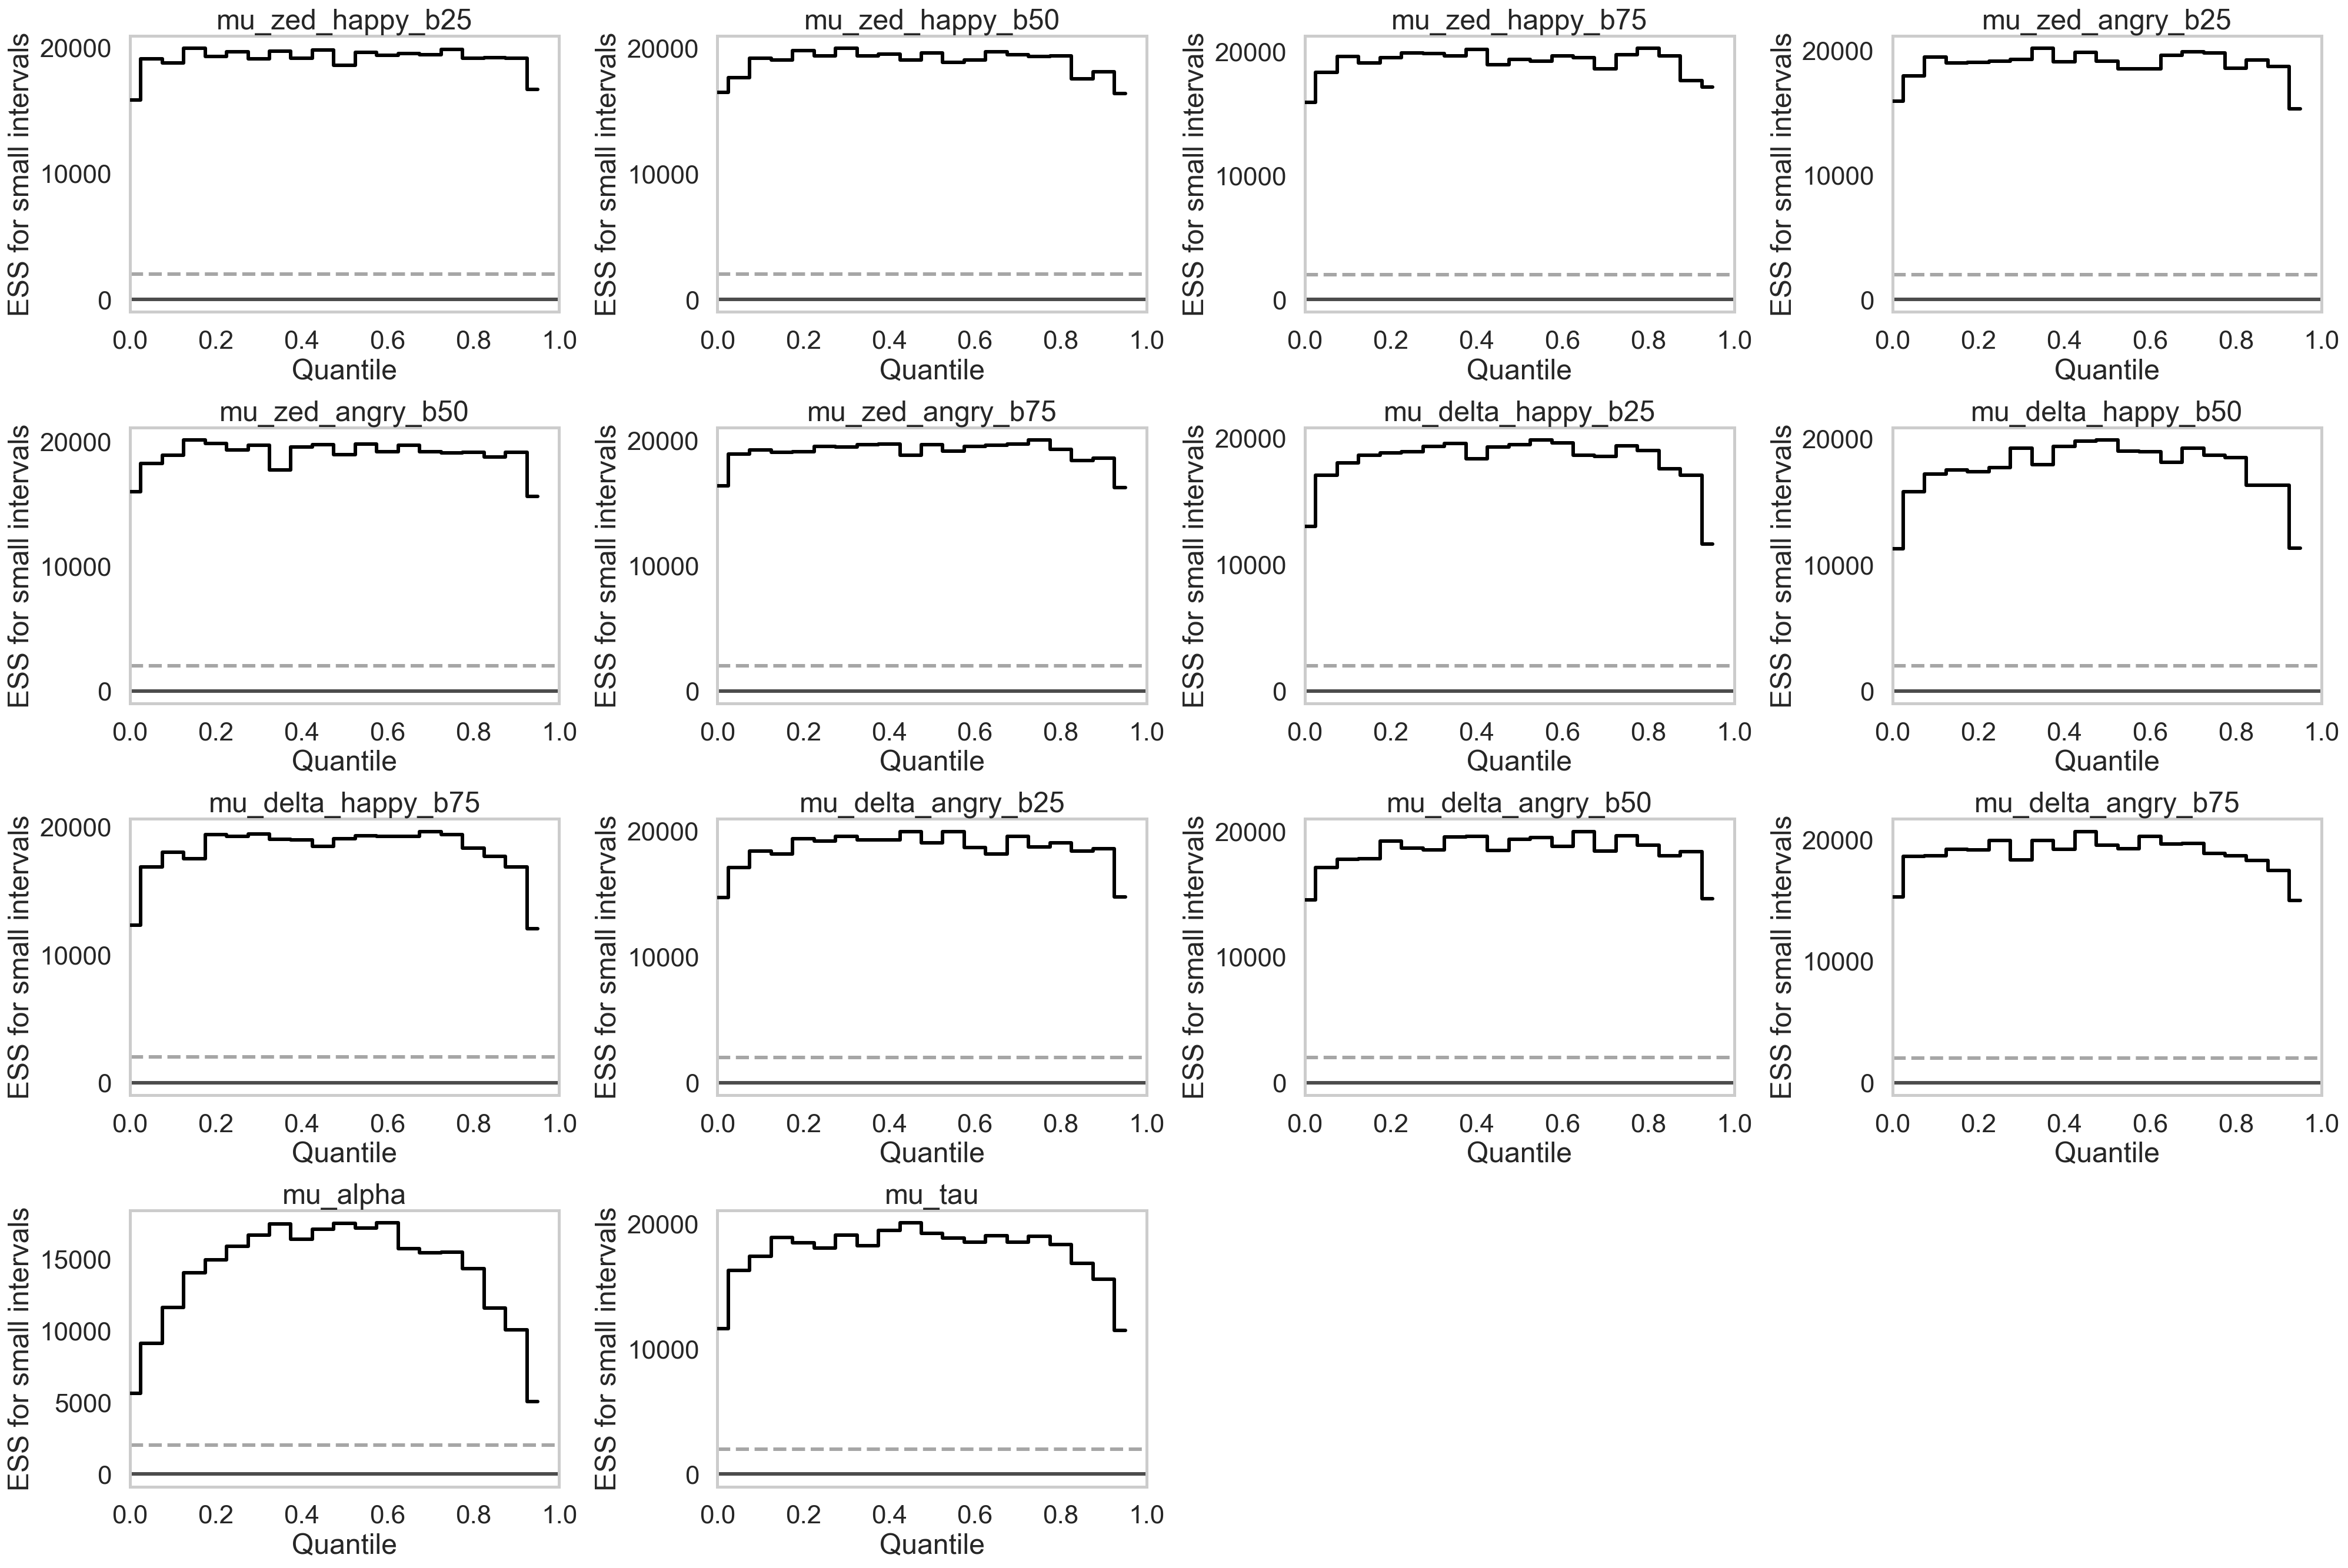

In [11]:
modeldata = azdf1
az.plot_ess(
    modeldata, kind="local", var_names=rhatvars, drawstyle="steps-mid", color="k",
    linestyle="-", marker=None, rug=True, rug_kwargs={"color": "r"}, min_ess=2000
)